# State Farm Work Assignment
1. Load the training and test data
2. explore data set for feature types, missing data and etc
    * feature selection
    * feature correlation matrix
3. Build the 1st linear regression model and test its accuracy
4. Feature extraction for the loan reason (bag of words, tf-idf, hashing etc)
5. Build simple linear regression model without highly-correlated features
6. Build second model (regression tree, random forest or polynomial features, SVM etc)

# Load the dataset and explore it

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import csv,re,os,codecs
from datetime import datetime
import nltk
from sklearn import feature_extraction
# coding: utf-8
pd.set_option('mode.chained_assignment',None)
%matplotlib inline

In [29]:
def money_cleaner(money_str):
    #remove dollar sign and coma for money
    from re import sub
    from decimal import Decimal
    return Decimal(sub(r'[^\d\-.]','',money_str))


In [30]:
# read the metadata into a dictionary
with open('Metadata.csv','r') as fh_meta:
    metadata = dict(filter(None, csv.reader(fh_meta)))

In [31]:
train = pd.read_csv('Data for Cleaning & Modeling.csv',sep=',',header=0,low_memory=False,date_parser=[14,22],na_values=[]) 
train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32
0,11.89%,54734.0,80364.0,"$25,000","$25,000","$19,080",36 months,B,B4,NaN,...,Feb-94,0.0,NaN,NaN,10.0,0.0,28854.0,52.10%,42.0,f
1,10.71%,55742.0,114426.0,"$7,000","$7,000",$673,36 months,B,B5,CNN,...,Oct-00,0.0,NaN,NaN,7.0,0.0,33623.0,76.70%,7.0,f
2,16.99%,57167.0,137225.0,"$25,000","$25,000","$24,725",36 months,D,D3,Web Programmer,...,Jun-00,0.0,41.0,NaN,10.0,0.0,19878.0,66.30%,17.0,f
3,13.11%,57245.0,138150.0,"$1,200","$1,200","$1,200",36 months,C,C2,city of beaumont texas,...,Jan-85,0.0,64.0,NaN,5.0,0.0,2584.0,40.40%,31.0,f
4,13.57%,57416.0,139635.0,"$10,800","$10,800","$10,692",36 months,C,C3,State Farm Insurance,...,Dec-96,1.0,58.0,NaN,14.0,0.0,3511.0,25.60%,40.0,f


In [32]:
test = pd.read_csv('Holdout for Testing.csv',sep=',',header=0,low_memory=False,date_parser=[14,22],na_values=[])
test.head()


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32
0,NaN,44409194,47416907,"$6,000","$6,000","$6,000",36 months,C,C5,Electrician,...,2-Nov,1,26.0,NaN,18,0,19861,64.50%,33,f
1,NaN,44017917,47034722,"$24,000","$24,000","$24,000",36 months,A,A1,Executive Assistant,...,Dec-68,1,NaN,NaN,12,0,17001,26.20%,36,w
2,NaN,44259158,47306871,"$35,000","$35,000","$35,000",36 months,C,C2,District Sales Leader,...,Oct-98,0,NaN,NaN,16,0,25797,49.90%,33,w
3,NaN,44429213,47476932,"$10,000","$10,000","$10,000",60 months,D,D1,pharmacy associate,...,Feb-99,1,NaN,114.0,13,1,9586,43.80%,21,w
4,NaN,44299188,47346901,"$24,000","$24,000","$24,000",60 months,B,B1,Medical case manager,...,2-Dec,0,48.0,NaN,27,0,31842,41.30%,43,w


In [33]:
#columns to transform and clean up after converting types
for n in train.columns:
    if (train.dtypes[n] == 'object'):
        #print("Converting column %s to String Type."%n)
        train[n] = train[n].astype('str')       
#same for test dataset, just in case there are difference
for n in test.columns:   
    if (test.dtypes[n] == 'object'):
        #print("Converting column %s to String Type."%n)
        test[n] = test[n].astype('str')       

In [34]:
#merge training and test data set for transforming and cleaning
train['X1'] = train['X1'].apply(lambda x: float(x.rstrip('%')))
all_data = train.append(test)
print(train.shape[:],test.shape[:],all_data.shape[:])

((400000, 32), (80000, 32), (480000, 32))


In [35]:
#make sure data merged correctly
assert str(all_data.iloc[400001]['X16']) == str(test.iloc[1]['X16']),"Hey,Someting is wrong after merge at column " + col
assert str(all_data.iloc[400001]['X4']) == str(test.iloc[1]['X4']),"Hey,Someting is wrong after merge at column " + col

## Data transforming and cleaning.
```#cols_cleanup = ['X1','X4','X5','X6','X7','X11','X15','X23','X30','X19']
```

In [36]:
all_data['X30'] = all_data['X30'].apply(lambda x: float(x.rstrip('%')))

In [37]:
all_data['X4'] = all_data['X4'].apply(lambda x:float(x.replace('$','').replace(',','')))
all_data['X5'] = all_data['X5'].apply(lambda x:float(x.replace('$','').replace(',','')))
all_data['X6'] = all_data['X6'].apply(lambda x:float(x.replace('$','').replace(',','')))
all_data['X7'] = all_data['X7'].apply(lambda x:float(x.split()[0]))
all_data['X19'] = all_data['X19'].apply(lambda x: float(x[0:3]))

In [38]:
#special treatment for number of year empoloyed
# < 1 year set to zero; >=10 to 10
def num_year_employed_strip(string):
    num_year_employed = re.findall("[-\d]+",string)
    if(len(num_year_employed) == 0):
        return np.nan
    elif((string.find('<') == 0) and (len(num_year_employed) >= 1)):
        return 0
    else:
        return float(num_year_employed[0])
    
all_data['X11'] = all_data['X11'].apply(lambda x: num_year_employed_strip(x) )

In [39]:
def x15_parser(d):
        try:
            return datetime.strptime(d,'%b-%d')
        except ValueError:
            return np.nan
        else:
            return datetime.strptime(d,'%d-%b')
        
all_data['X15'] = all_data['X15'].apply(lambda d: x15_parser(d))



In [40]:
#X23 is more complicated than x15 as it contains day-month and Mon-Year
def x23_parser(d):
    try:
        return datetime.strptime(d,'%b-%y')
    except ValueError:
        return np.nan
    else:
        return datetime.strptime(d,'%d-%b')
        
all_data['X23'] = all_data['X23'].apply(lambda d: x23_parser(d))        

In [41]:
#check any duplicate borrower and loans
assert len(all_data['X2'].unique()) == all_data.shape[0], "duplicate loans exist"
assert len(all_data['X3'].unique()) == all_data.shape[0], "duplicate borrowers exist"

## Process column X16 with TF-IDF and clustering for loan reasons
1. First remove stop words and stem it
2. Compute TF-IDF and then compute similarity matrix
3. Use K-mean cluster to group the loan reasons
4. Assign cluster group to a new loan reason

In [42]:
documents = all_data['X16'].tolist()
print (documents[0][0:200])  # first 20 characters

Due to a lack of personal finance education and exposure to poor financing skills growing up, I was easy prey for credit predators. I am devoted to becoming debt-free and can assure my lenders that I 


In [43]:
#stopwords, stemming and tokenizing
import nltk
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [44]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

## Try <a href="https://radimrehurek.com/gensim/tut2.html"> gensim for topic modeling </a>  

In [45]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.WARNING)

In [19]:
from gensim import corpora, models, similarities

C:\Anaconda2\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Anaconda2\lib\site-packages\gensim\utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [21]:
texts = [tokenize_and_stem(document.decode('utf-8')) for document in documents]

In [22]:
#dictionary = corpora.Dictionary(texts)  #{'we':11,'not':10,'loan',0} token:id
#dictionary.save('dict_token.dict')
corpora.Dictionary.load('dict_token.dict')

In [23]:
corpus = [dictionary.doc2bow(text) for text in texts]   #[(0,1),(1,1),(2,1)]

NameError: name 'texts' is not defined

In [23]:
print(corpus[0])

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 5), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 3), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1)]


In [ ]:
corpora.MmCorpus.serialize('dict_token.txt',corpus) # store to disk, for later use, serialize it one at a time

In [24]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

In [25]:
index = similarities.SparseMatrixSimilarity(tfidf[corpus],num_features=12)

Help on csr_matrix in module scipy.sparse.csr object:

class csr_matrix(scipy.sparse.compressed._cs_matrix, scipy.sparse.sputils.IndexMixin)
 |  Compressed Sparse Row matrix
 |  
 |  This can be instantiated in several ways:
 |      csr_matrix(D)
 |          with a dense matrix or rank-2 ndarray D
 |  
 |      csr_matrix(S)
 |          with another sparse matrix S (equivalent to S.tocsr())
 |  
 |      csr_matrix((M, N), [dtype])
 |          to construct an empty matrix with shape (M, N)
 |          dtype is optional, defaulting to dtype='d'.
 |  
 |      csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
 |          where ``data``, ``row_ind`` and ``col_ind`` satisfy the
 |          relationship ``a[row_ind[k], col_ind[k]] = data[k]``.
 |  
 |      csr_matrix((data, indices, indptr), [shape=(M, N)])
 |          is the standard CSR representation where the column indices for
 |          row i are stored in ``indices[indptr[i]:indptr[i+1]]`` and their
 |          corresponding value

### Corpus Streaming - One Document at a Time

In [ ]:
class MyCorpus(object):
    def __iter__(self):
        for line in documents:
            #Assume there is one document per line, tokens separated by whitespace
            yield dictionary.doc2bow(line.lower().split())

corpus_memory_friendly = MyCorpus()

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.7, max_features=2000,
                                 min_df=0.02, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,2))
#try 1000 documents
%time tfidf_matrix = tfidf_vectorizer.fit_transform(documents) #fit the vectorizer to corpus

print(tfidf_matrix.shape)

Wall time: 3min 41s
(480000, 38)


In [26]:
terms = tfidf_vectorizer.get_feature_names()
print(terms[0:max(tfidf_matrix.shape[1],50)])

[u'ad', u'ad loan', u'ad pay', u'borrow', u'borrow ad', u'br', u'br borrow', u'br br', u'br/', u'card', u'card debt', u'consolid', u'consolid credit', u'credit', u'credit card', u'current', u'debt', u'help', u'high', u'home', u'job', u'like', u'loan', u'lower', u'make', u'money', u'month', u'need', u'pay', u'pay credit', u'payment', u'rate', u'thank', u'time', u'use', u'want', u'work', u'year']


<b> It is a chanllenge to compute cosine_similarity in memory due to its size, PySpark will help here! </b>

In [20]:
#from sklearn.metrics.pairwise import pairwise_kernels  # significantly slower than cosine_similarity
#%time dist = 1 - pairwise_kernels(tfidf_matrix,metric='cosine',n_jobs=8)

In [21]:
#from sklearn.metrics.pairwise import cosine_similarity
#%time dist = 1 - cosine_similarity(tfidf_matrix)
#print(dist.shape)

In [22]:
# if memory error, loop to compute cosine_similarity
from scipy.spatial.distance import cosine
dist = np.empty([tfidf_matrix.shape[0],tfidf_matrix.shape[0]])  #symetric matrix
for n in range(tfidf_matrix.shape[0]):
    for m in range(n,tfidf_matrix.shape[0]):
        dist[n,m] = cosine(tfidf_matrix[m].todense(),tfidf_matrix[m].todense())
#fill the other half
print('fill the other half')
%time dist = np.maximum(dist,dist.T)

MemoryError: 

### K-means clustering

In [27]:
from sklearn.cluster import KMeans
num_clusters = 20  # 20 different kind of loan reasons should cover almost all 
km = KMeans(n_clusters = num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

Wall time: 11min 50s


In [52]:
print("Top terms per cluster")
order_centroids = km.cluster_centers_.argsort()[:,::-1]  # sort cluster centers by proximity to centroid

for i in range(num_clusters):
    #print("Cluster %d words: " % i,end=' ')
    print("cluster %d words" % i)
    for ind in order_centroids[i,:20]:
        #print("%s" % terms[ind], end=' ')
        print(''.join(terms[ind]))
    print()    

Top terms per cluster
cluster 0 words
want
use
help
money
work
thank
current
time
pay
make
job
month
ad
credit
high
debt
consolid
borrow
need
like
()
cluster 1 words
debt
card debt
card
credit
credit card
br
borrow
ad
borrow ad
pay
loan
consolid
pay credit
payment
year
high
rate
ad loan
use
month
()
cluster 2 words
br
ad
borrow
borrow ad
debt
want
pay
help
loan
use
thank
credit
money
work
high
make
payment
time
month
current
()
cluster 3 words
rate
credit
card
br
lower
borrow
ad
borrow ad
credit card
pay
high
loan
debt
consolid
payment
want
like
month
year
use
()
cluster 4 words
ad pay
pay
br
borrow
ad
borrow ad
credit
high
card
credit card
loan
debt
rate
payment
month
home
br/
br borrow
br br
lower
()
cluster 5 words
like
br
borrow
ad
borrow ad
pay
credit
card
credit card
consolid
loan
debt
payment
high
month
rate
pay credit
thank
use
money
()
cluster 6 words
consolid
br
borrow
borrow ad
ad
loan
credit
want
payment
high
pay
use
month
lower
rate
help
thank
card
money
make
()
cluster 7 

In [47]:
all_data['X16'] = clusters   #assign cluster group code to number of loan reasons

In [56]:
print(set(all_data['X16']))

set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])


### Change data type to categorical 
``` categorical_cols = ['X8','X9','X10','X12','X14','X17','X20','X32'] #possibly 'X13','X16'
```

In [23]:
categorical_cols = ['X8','X9','X10','X12','X14','X17','X18','X20','X32','X16'] 
for col in categorical_cols:
    all_data[col] = all_data[col].astype('category')

In [24]:
#assign data back to train and test
train_processed = all_data.iloc[0:train.shape[0]]
test_processed = all_data.iloc[train.shape[0]:]

## Check how many missing data in the training and test data



In [25]:
#percentage of data missing
missing_pct_train = train_processed.isnull().sum()/train_processed.shape[0]
missing_pct_train.sort_values(ascending=False,inplace=True)

print("The top Six data is in column (percentage) " )
for n in range(6):
    print(missing_pct_train.keys()[n],metadata[missing_pct_train.keys()[n]],missing_pct_train.values[n])

The top Six data is in column (percentage) 
('X26', 'Number of months since the last public record.', 0.87211249999999996)
('X25', "Number of months since the borrower's last delinquency.", 0.54700499999999996)
('X13', 'Annual income of borrower', 0.15257000000000001)
('X1', 'Interest Rate on the loan', 0.15252499999999999)
('X11', 'Number of years employed (0 to 10; 10 = 10 or more)', 0.043845000000000002)
('X30', 'Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.', 0.00066750000000000002)


### process missing data in training dataset
1. remove record where no interest rate on the loan , about 15% record
2. remove record (row) where columns (X2,X3 etc)  less than 0.1%
3. Special treatment for X26(num months since last deliquency),X25(num inquiries),X13(annual income),X11 (number year employed)

In [26]:
# remove record with no interest rate in the training data set
train_processed_s1 = train_processed[~np.isnan(train_processed['X1'])]
print('step 1: %d rows' %train_processed_s1.shape[0])
missing_threshold = 0.001
# remove record (row) where columns (X2,X3 etc) less than threshold
for n in range(len(missing_pct_train)):
    if(missing_pct_train.get_value(n) <= missing_threshold ):
        key = missing_pct_train.keys()[n]
        train_processed_s1.dropna(subset=[key],inplace=True)
print('step 2: %d rows' %train_processed_s1.shape[0])


step 1: 338990 rows
step 2: 338765 rows


In [27]:
# process X26, X25
# X26: num of months since last deliquency, assume NaN is zero if no record
train_processed_s1['X26'].fillna(0,inplace=True)
# X25: num inquiries, assume NaN is zero if no record
train_processed_s1['X25'].fillna(0,inplace=True)

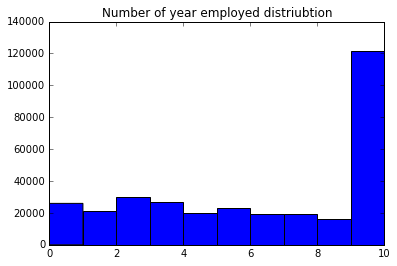

In [28]:
# X11: number of year employed (less than 5%), drop it for now
plt.hist(train_processed_s1['X11'],10,range=[0,10])
plt.title('Number of year employed distriubtion')
train_processed_s1.dropna(inplace=True)

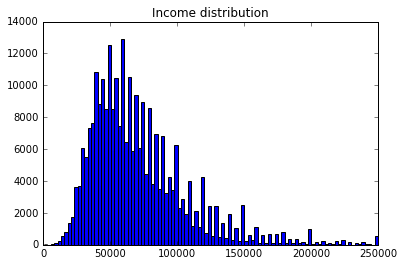

In [29]:

# X13: Annual Income of borrower (15%), it would be great if there is another model to predict people's income
plt.hist(train_processed_s1['X13'][~np.isnan(train_processed_s1['X13'])],100,range = [1000,250000])
plt.title('Income distribution')
#try fill na with median value
train_processed_s1_medianX13 = train_processed_s1.copy(deep=True)
train_processed_s1_medianX13['X13'] = train_processed_s1['X13'].fillna(train_processed_s1['X13'].median())
#option two, drop it all
train_processed_s1_dropX13 = train_processed_s1.copy(deep=True)
train_processed_s1_dropX13['X13'].dropna(inplace=True)


In [30]:
assert train_processed_s1_dropX13.isnull().sum().sum()==0,"there are still missing value in the training data set"
assert train_processed_s1_medianX13.isnull().sum().sum()==0,"there are still missing value in the training data set"

### process missing data in test dataset

In [31]:
#test_processed = all_data.iloc[train.shape[0]:]

In [32]:
missing_test_pct = test_processed.isnull().sum()/test.shape[0]
missing_test_pct.sort_values(ascending=False,inplace=True)

print("The missing data percentage (total 7) is in column (percentage) " )
for n in range(7):
    print(missing_test_pct.keys()[n],metadata[missing_test_pct.keys()[n]],missing_test_pct.values[n])

The missing data percentage (total 7) is in column (percentage) 
('X1', 'Interest Rate on the loan', 1.0)
('X15', 'Date loan was issued', 1.0)
('X26', 'Number of months since the last public record.', 0.82701250000000004)
('X25', "Number of months since the borrower's last delinquency.", 0.48380000000000001)
('X23', "Date the borrower's earliest reported credit line was opened", 0.42521249999999999)
('X11', 'Number of years employed (0 to 10; 10 = 10 or more)', 0.054774999999999997)
('X30', 'Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.', 0.00037500000000000001)


### columns with missing test data
``` missing_test_cols = ['X26','X25','X23','X11','X15']```



In [33]:
# remove record (row) where columns (X30 etc) less than threshold,doesn't apply for test dataset due to score purpose
#for n in range(len(missing_test_pct)):
#    if(missing_test_pct.get_value(n) <= missing_threshold ):
#        key = missing_test_pct.keys()[n]
#        test_processed.dropna(subset=[key],inplace=True)
#print('step 1: %d rows' %test_processed.shape[0])
test_processed['X11'].fillna(0,inplace=True)
test_processed['X30'].fillna(0,inplace=True)  # assume 0 if no line utilization

In [34]:
# drop column X15 since it 100% missing, for consistence with training data set, just keep it with 0 filled
#test_processed.drop('X15',axis=1,inplace=True)
test_processed['X15'].fillna(0,inplace=True)  # 'X15' won't be used in model
# process X26, X25, X13,X11
# X26: num of months since last deliquency, assume NaN is zero if no record
test_processed['X26'].fillna(0,inplace=True)
# X25: num inquiries, assume NaN is zero if no record
test_processed['X25'].fillna(0,inplace=True)
# X11 drop it
#test_processed.dropna(inplace=True)
# X13 
#try fill na with median value
test_processed_medianX13 = test_processed.copy(deep=True)
test_processed_medianX13['X13'] = test_processed_medianX13['X13'].fillna(test_processed['X13'].median())
#option two, drop it all
#test_prpcessed_dropX13 = test_processed.copy(deep=True)
#test_prpcessed_dropX13['X13'].dropna(inplace=True)

In [35]:
test_processed.shape

(80000, 32)

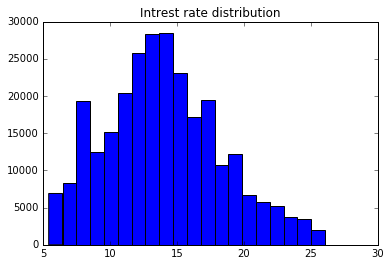

In [36]:
# check interest rate 
plt.hist(train_processed_s1['X1'],bins = 20)
plt.title('Intrest rate distribution')

# Merge processed train and test data for label encoding

In [37]:
#use the dropped training dataset
all_data_clean_median = train_processed_s1_dropX13.append(test_processed_medianX13)

In [38]:
categorical_cols_2 = ['X8','X9','X10','X12','X14','X17','X18','X20','X32']

In [39]:
# apply label encoding for category dataset
from sklearn import preprocessing
le  = preprocessing.LabelEncoder()
for col in categorical_cols_2:
    all_data_clean_median[col] = le.fit_transform(all_data_clean_median[col])
        

In [40]:
train_use = all_data_clean_median.iloc[0:train_processed_s1_dropX13.shape[0]]
test_use = all_data_clean_median.iloc[train_processed_s1_dropX13.shape[0]::]

In [41]:
test_use.shape


(80000, 32)

In [42]:
# explore colinearilty between features
features_exclude = ['X16','X15','X23','X2','X3']
#feature_cols = [col for col in train_use.columns if col not in features_exclude]
feature_cols = ['X4','X5','X6','X11','X13','X24','X22','X25','X26','X27','X28','X30','X31']
corr = np.corrcoef(train_use[feature_cols],rowvar=0)
w, v = np.linalg.eig(corr)        # eigen values & eigen vectors


In [43]:
#check colinearity
pd.DataFrame(corr,index=feature_cols,columns=feature_cols)

,X4,X5,X6,X11,X13,X24,X22,X25,X26,X27,X28,X30,X31
X4,1.000000,0.998242,0.993923,0.122649,0.350427,-0.002003,0.007060,-0.026649,-0.091352,0.198835,-0.070701,0.117450,0.235782
X5,0.998242,1.000000,0.996040,0.123190,0.349766,-0.002227,0.007699,-0.025952,-0.090819,0.199798,-0.070085,0.118752,0.235669
X6,0.993923,0.996040,1.000000,0.126012,0.347909,-0.003975,0.008655,-0.025036,-0.089271,0.200939,-0.068433,0.121285,0.236241
X11,0.122649,0.123190,0.126012,1.000000,0.071581,-0.007878,0.032481,0.035731,0.052224,0.045154,0.039499,0.046588,0.117558
X13,0.350427,0.349766,0.347909,0.071581,1.000000,0.064222,0.059219,0.020011,-0.042332,0.149543,-0.007936,0.031573,0.220052
X24,-0.002003,-0.002227,-0.003975,-0.007878,0.064222,1.000000,0.024647,0.034436,0.030407,0.099910,0.037840,-0.096677,0.133277
X22,0.007060,0.007699,0.008655,0.032481,0.059219,0.024647,1.000000,-0.054897,-0.024427,0.059226,-0.007483,-0.011034,0.130531
X25,-0.026649,-0.025952,-0.025036,0.035731,0.020011,0.034436,-0.054897,1.000000,0.031526,0.026760,0.060610,0.007775,0.115495
X26,-0.091352,-0.090819,-0.089271,0.052224,-0.042332,0.030407,-0.024427,0.031526,1.000000,-0.033570,0.670360,-0.042946,-0.024885
X27,0.198835,0.199798,0.200939,0.045154,0.149543,0.099910,0.059226,0.026760,-0.033570,1.000000,-0.025467,-0.116872,0.678517


Based on the colinearity of the numerical features, there are strong colinearity between X4,X5,X6; and X26,X28; X27,X31

# Build Model 1: Linear Regression - only use numerical features

In [44]:
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
train_split, crossVal = train_test_split(train_use, test_size = 0.2, random_state = 100)

In [45]:
feature_cols = ['X4','X5','X6','X11','X13','X24','X21','X22','X25','X26','X27','X28','X30','X31'] #numerical feature first
x = train_use[feature_cols]
y = train_use['X1']
clf = Ridge(alpha = 1.0)
clf.fit(x,y)
# predict validation
x_val = crossVal[feature_cols]
y_pred = clf.predict(x_val)
print("The R2 for train model is: %f"%clf.score(x,y))
print("The R2 score for validation model is %f" %r2_score(crossVal['X1'],y_pred))
print("The RMSE for validation model is %f" %mean_squared_error(crossVal['X1'],y_pred)**(1/2.0))

The R2 for train model is: 0.253588
The R2 score for validation model is 0.254896
The RMSE for validation model is 3.782509


## Model 1.1- remove colinearilty features

In [47]:
feature_cols = ['X4','X11','X13','X24','X22','X21','X25','X26','X27','X30']  # remove X5,X6,X31
x = train_use[feature_cols]
y = train_use['X1']
clf = Ridge(alpha = 1.0)
clf.fit(x,y)
# predict validation
x_val = crossVal[feature_cols]
y_pred = clf.predict(x_val)
print("The R2 for train model is: %f"%clf.score(x,y))
print("The R2 score for validation model is %f" %r2_score(crossVal['X1'],y_pred))
print("The RMSE for validation model is %f" %mean_squared_error(crossVal['X1'],y_pred)**(1/2.0))

The R2 for train model is: 0.238472
The R2 score for validation model is 0.242129
The RMSE for validation model is 3.814778


In [48]:
pd.DataFrame(np.array([y_pred,crossVal['X1']]),index=['prediction','actual'])

,0,1,2,3,4,5,6,7,8,9,...,54886,54887,54888,54889,54890,54891,54892,54893,54894,54895
prediction,13.79916,15.009684,11.823187,16.194972,12.496613,13.462928,12.134427,18.312617,16.491955,10.328818,...,15.620492,11.711222,11.622011,9.911512,16.542575,14.035354,15.143918,12.269129,13.238484,13.897741
actual,12.12000,20.200000,7.620000,9.170000,12.530000,17.570000,10.640000,15.610000,20.200000,6.030000,...,24.990000,10.990000,16.590000,14.330000,16.590000,7.900000,16.290000,7.120000,13.040000,10.990000


## Model 1.2 - add categorical features

In [44]:
features_exclude = ['X1','X2','X3','X5','X6','X15','X16','X23','X31','Load_Reason_Hash']
feature_cols = [col for col in train_use.columns if col not in features_exclude]
print(feature_cols)
#feature_cols = ['X4','X11','X13','X24','X22','X25','X26','X27','X30','X18']  # remove X5,X6,X31

x = train_use[feature_cols]
y = train_use['X1']
clf = Ridge(alpha = 1.0)
clf.fit(x,y)
# predict validation
x_val = crossVal[feature_cols]
y_pred = clf.predict(x_val)
print("The R2 for train model is: %f"%clf.score(x,y))
print("The R2 score for validation model is %f" %r2_score(crossVal['X1'],y_pred))
print("The RMSE for validation model is %f" %mean_squared_error(crossVal['X1'],y_pred)**(1/2.0))

['X4', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X32']
The R2 for train model is: 0.556391
The R2 score for validation model is 0.555898
The RMSE for validation model is 2.920204


In [45]:
pd.DataFrame(np.transpose(np.array([y_pred,crossVal['X1']])),
             columns=['Prediction','Actural']).to_csv('cross_metric.csv',sep=',',header=True)

## Apply first model on test data set


In [46]:
x = test_use[feature_cols]
test_pred = clf.predict(x)
np.savetxt('Results from Liang Kuang-Model I.csv',test_pred, fmt='%8.3f',
           delimiter=',',newline='\n',header='Predicted Interest Rate')

## Build Model 2 using Random Forest Regressor

In [47]:
from sklearn.ensemble import RandomForestRegressor
features_exclude = ['X1','X2','X3','X5','X6','X15','X16','X23','X31','Load_Reason_Hash']
feature_cols = [col for col in train_use.columns if col not in features_exclude]
print(feature_cols)
x = train_use[feature_cols]
y = train_use['X1']

regressor = RandomForestRegressor(n_estimators=100, min_samples_split=1)
regressor.fit(x, y)
#predict for cross_validation
x_val = crossVal[feature_cols]
y_pred = regressor.predict(x_val)
print("The RMSE for validation model is %f" %mean_squared_error(crossVal['X1'],y_pred)**(1/2.0))


['X4', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X32']
The RMSE for validation model is 0.516804


In [48]:
x = test_use[feature_cols]
test_pred = regressor.predict(x)
np.savetxt('Results from Liang Kuang-Model II.csv',test_pred, fmt='%8.3f',
           delimiter=',',newline='\n',header='Predicted Interest Rate')

# Build Model 3 using SVM for non-linear features

In [ ]:
# SVM requires scaleing features, otherwise it may stuck on local minimum
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(train_use)  
X_train = scaler.transform(train_use)  
#apply same transformation to test data
X_test = scaler.transform(test_use)  
train_split, crossVal = train_test_split(X_train, test_size = 0.2, random_state = 100)

In [ ]:
from sklearn.svm import SVR
features_exclude = ['X1','X2','X3','X5','X6','X15','X16','X23','X31','Load_Reason_Hash']
feature_cols = [col for col in train_use.columns if col not in features_exclude]
print(feature_cols)

x = train_use[feature_cols]
y = train_use['X1']
svm_regressor = SVR(kernel='poly',C=1e3,degree=2)
svm_regressor.fit(x,y)
# predict validation
x_val = crossVal[feature_cols]
y_pred = svm_regressor.predict(x_val)
print("The R2 for train model is: %f"%svm_regressor.score(x,y))
print("The R2 score for validation model is %f" %r2_score(crossVal['X1'],y_pred))
print("The RMSE for validation model is %f" %mean_squared_error(crossVal['X1'],y_pred)**(1/2.0))

In [ ]:
x = test_use[feature_cols]
test_pred = svm_regressor.predict(x)
np.savetxt('Results from Liang Kuang-Model II.csv',test_pred, fmt='%8.3f',
           delimiter=',',newline='\n',header='Predicted Interest Rate')